In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [ ]:
#---------- CHOOSE MUNICIPALITIES TO ANALISE (CVEGEO) ----------
cvegeo_list = ['08019','08038','08045','08004','08055']
#08019 - Chihuahua municipality ('Paso del Norte y 'Nuevas Delicias')
#08038 y 08045 - Julimes + Meoqui municipalities ('La Regina')
#08055 (Rosales) and 08004 (Aquiles Serdán) connect 'La Regina' with 'Paso del Norte' and 'Nueva Delicias' in case there is a reason for the whole network to be connected.

#08051 - Ocampo municipality ('Basaseachi') is isolated and does not have a network

#---------- SPECIFY AMENITY NAME CURRENTLY ANALIZED ----------
a = str('agua') #a is the name of the amenity currently examined
correction = True #If updating previously calculated proximity for specific amenity

#---------- SPECIFY CITY OF ANALISIS ----------
c = 'designforvulnerables'
#c corresponds to 'city', which in this case will be 'designforvulnerables.

## Data download

<Axes: >

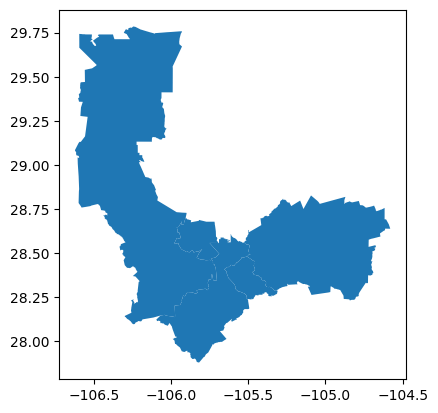

In [3]:
#Query municipalities
mun_schema = 'marco'
mun_table = 'mpos_2020'


mun_gdf = gpd.GeoDataFrame()
# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    mun_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    mun_gdf = pd.concat([mun_gdf, mun_tmp],
    ignore_index = True, axis = 0)

#Define projections and plot
mun_gdf = mun_gdf.set_crs("EPSG:4326")
mun_gdf.plot()

In [5]:
#Load points of interest and filter for relevant data
pois = gpd.read_file("../../../data/external/temporal_todocker/prueba_pois_agua.gpkg")
points = pois[['TIPO','geometry']]

#Review result
print(points.shape)
points.head(2)

(240, 2)


,TIPO,geometry
0,Tanque Elevado,POINT (-105.42449 28.42276)
1,Tanque Elevado,POINT (-105.46400 28.44415)


## Proximity analysis

### Proximity analysis - 01 Find closest osmnx node to each point of interest

Create network

In [6]:
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx')

In [7]:
points = points.set_crs("EPSG:4326")
nodes = nodes.set_crs("EPSG:4326")
edges = edges.set_crs("EPSG:4326")

Find nearest node for each point (Returns points gdf with osmid and distance info)

In [8]:
nearest = aup.find_nearest(G, nodes, points, return_distance= True)
nearest = nearest.set_crs("EPSG:4326")

In [9]:
#Review result
print(nearest.shape)
nearest.head(2)

(240, 4)


,TIPO,geometry,osmid,distance_node
0,Tanque Elevado,POINT (-105.42449 28.42276),3056531683,45.210165
1,Tanque Elevado,POINT (-105.46400 28.44415),7072576136,535.969389


### Proximity analysis - 02 Find min distance from nodes to points of interest (previously assigned node)

Data treatment for nodes and edges

In [13]:
#Nodes: Reset index
nodes_analysis = nodes.reset_index().copy()

#Nodes: Create df_temp, each column will be a batch of procesed nodes.
df_temp = nodes.copy()

#Nodes: Create nodes_distance. Minimum time/lenght found in all batches will be added from df_min to nodes_distance.
nodes_distance = nodes.copy()

Find distance to nearest point

In [14]:
#Set batch size
batches = len(nearest)/250

for k in range(int(batches)+1):
            
            #Divide points in batches
            points_process = nearest.iloc[int(250*k):int(250*(1+k))].copy()
            
            #Calculate the distance of each node to currently examined amenity
            nodes_distance_prep = aup.calculate_distance_nearest_poi(points_process, nodes_analysis, 
            edges, a, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the group number it belongs to
            df_int = pd.DataFrame()
            df_int['dist'+str(k)+a] = nodes_distance_prep['dist_'+a]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)

#Drop the non-distance values from the temporary gdf
df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)

#Review result
print(df_temp.shape)
df_temp.head(2)

(65887, 1)


,dist0agua
osmid,
230565134,1108.276
230565138,1279.663


Find minimum value of all batches

In [15]:
df_min = pd.DataFrame()
df_min['dist_'+a] = df_temp.min(axis=1)
df_min.head()

,dist_agua
osmid,
230565134,1108.276
230565138,1279.663
230565140,1203.364
230579435,2132.731
230605901,1797.941


Add minimum value to nodes_distance

In [16]:
nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
nodes_distance.head(2)

,x,y,street_count,geometry,dist_agua
osmid,,,,,
230565134,-106.147366,28.728815,3,POINT (-106.14737 28.72881),1108.276
230565138,-106.110401,28.687995,3,POINT (-106.11040 28.68799),1279.663


Convert distance to time data (Walking speed = 4km/hr)

In [17]:
nodes_time = nodes_distance.copy()
nodes_time['time_'+a] = (nodes_time['dist_'+a]*60)/4000
nodes_time.head(2)

,x,y,street_count,geometry,dist_agua,time_agua
osmid,,,,,,
230565134,-106.147366,28.728815,3,POINT (-106.14737 28.72881),1108.276,16.624140
230565138,-106.110401,28.687995,3,POINT (-106.11040 28.68799),1279.663,19.194945


### Proximity analysis - 03 Save data

Create nodes_amenities from formated nodes_distance

In [39]:
nodes_time.reset_index(inplace=True)
nodes_amenities = nodes_time[['osmid','x','y','geometry','time_'+a]]
nodes_amenities = nodes_amenities.set_crs("EPSG:4326")
nodes_amenities

,osmid,x,y,geometry,time_agua
0,230565134,-106.147366,28.728815,POINT (-106.14737 28.72881),16.624140
1,230565138,-106.110401,28.687995,POINT (-106.11040 28.68799),19.194945
2,230565140,-106.110667,28.683645,POINT (-106.11067 28.68364),18.050460
3,230579435,-106.125950,28.704553,POINT (-106.12595 28.70455),31.990965
4,230605901,-106.091230,28.656325,POINT (-106.09123 28.65632),26.969115
...,...,...,...,...,...
65882,9416668921,-106.082459,28.658955,POINT (-106.08246 28.65895),12.230505
65883,9416668922,-106.082590,28.658824,POINT (-106.08259 28.65882),12.462510
65884,9416668923,-106.082641,28.659113,POINT (-106.08264 28.65911),12.604755
65885,9416668924,-106.083658,28.659994,POINT (-106.08366 28.65999),14.696190


Join currently examined nodes with previously examined nodes

In [38]:
#------------------------------- ERROR -----------------------------------------------
#nodes_proximity_dfv = aup.gdf_from_db('nodes_proximity_dfv','projects_research')
#nodes_proximity_dfv.head(2)
#------------------------------- ERROR -----------------------------------------------
mun_schema = 'projects_research'
mun_table = 'nodes_proximity_dfv'

query = f"SELECT * FROM {mun_schema}.{mun_table}"
nodes_proximity_dfv = aup.gdf_from_query(query, geometry_col='geometry')

print(nodes_proximity_dfv.shape)
nodes_proximity_dfv.head(2)

(65887, 6)


,osmid,time_agua,city,x,y,geometry
0,230565134,16.624140,designforvulnerables,-106.147366,28.728815,POINT (-106.14737 28.72881)
1,230565138,19.194945,designforvulnerables,-106.110401,28.687995,POINT (-106.11040 28.68799)


In [40]:
# Just the first time for each city

if c in nodes_proximity_dfv.city.unique().tolist():
    nodes_amenities = nodes_proximity_dfv.merge(nodes_amenities[['osmid','time_'+a]], on='osmid',how='outer')
    nodes_amenities = nodes_amenities.set_crs("EPSG:4326")
else:
    nodes_amenities['city'] = c
    nodes_amenities = pd.concat([nodes_proximity_dfv,nodes_amenities])
    nodes_amenities = nodes_amenities.set_crs("EPSG:4326")

print(nodes_amenities.shape)
nodes_amenities.head(2)

(65887, 7)


,osmid,time_agua_x,city,x,y,geometry,time_agua_y
0,230565134,16.624140,designforvulnerables,-106.147366,28.728815,POINT (-106.14737 28.72881),16.624140
1,230565138,19.194945,designforvulnerables,-106.110401,28.687995,POINT (-106.11040 28.68799),19.194945


In [42]:
if correction:
    nodes_amenities.drop(columns='time_{}_x'.format(a),inplace=True)
    nodes_amenities.rename(columns={'time_{}_y'.format(a):'time_{}'.format(a)},inplace=True)

print(nodes_amenities.shape)
nodes_amenities.head(2)

(65887, 6)


,osmid,city,x,y,geometry,time_agua
0,230565134,designforvulnerables,-106.147366,28.728815,POINT (-106.14737 28.72881),16.624140
1,230565138,designforvulnerables,-106.110401,28.687995,POINT (-106.11040 28.68799),19.194945


In [43]:
#Find current available columns
cols = nodes_amenities.columns.tolist()

#Remove base columns to reorder
cols.remove('x')
cols.remove('y')
cols.remove('geometry')
cols.remove('city')

#Add base columns to reorder
cols.append('city')
cols.append('x')
cols.append('y')
cols.append('geometry')

#Save new order
nodes_format = nodes_amenities[cols]

#Review result
print(nodes_format.shape)
nodes_format.head(2)

(65887, 6)


,osmid,time_agua,city,x,y,geometry
0,230565134,16.624140,designforvulnerables,-106.147366,28.728815,POINT (-106.14737 28.72881)
1,230565138,19.194945,designforvulnerables,-106.110401,28.687995,POINT (-106.11040 28.68799)


Save to db

In [44]:
nodes_proximity_dfv =gpd.GeoDataFrame(nodes_format, geometry='geometry')

In [ ]:
aup.gdf_to_db_slow(nodes_proximity_dfv,'nodes_proximity_dfv','projects_research',if_exists="replace")